# The JHU COVID Database

**Introduction**

The Johns Hopkins University maintains an online COVID-19 database that is uplodaded as a public github repo: https://github.com/CSSEGISandData/COVID-19.git. 

We are interested in mining out some useful information regarding confirmed COVID cases for different countries from this database.

In this article, we will try to analyze the data in the JHU database that contains the information on confirmed COVID cases for different countries/regions and provinces/states. 

### Import the libraries

In [1]:
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import axes
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

### Read all the datasets

In [2]:
# read all the datasets

confirmed_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
death_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
confirmed_us = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
death_us = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
recovered_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")


### Data Transformation

In [3]:
def melt_function(df, val_name):
    """
    Melt wide form data into long form data for operation
    :params df: Long form dataset
    :params df: count value

    :return: long form dataset
    """
    melt_df = df.melt(id_vars=['Country/Region'],
                                var_name='date_ts',
                                value_vars=df.columns[4:],
                                value_name=val_name
                                )
    return melt_df

## Global Cumulative Data

In [4]:
confrm_melt = melt_function(confirmed_global, 'confirm_val')
death_melt = melt_function(death_global, 'death_val')
recov_melt = melt_function(recovered_global, 'recov_val')
confrm_melt = confrm_melt.rename(columns={'Country/Region': 'Country'})
death_melt = death_melt.rename(columns={'Country/Region': 'Country'})
recov_melt = recov_melt.rename(columns={'Country/Region': 'Country'})
confrm_melt.tail()

,Country,date_ts,confirm_val
288128,West Bank and Gaza,10/14/22,702804
288129,Winter Olympics 2022,10/14/22,535
288130,Yemen,10/14/22,11939
288131,Zambia,10/14/22,333624
288132,Zimbabwe,10/14/22,257827


In [5]:
final_melt = confrm_melt.merge(death_melt, on=['Country', 'date_ts'], how='left', suffixes=('_conf', '_dth')) \
                        .merge(recov_melt, on=['Country', 'date_ts'], how='left', suffixes=('_both', '_rcvr')) 
            #  .join(recov_melt, on=['Country', 'date_ts'], how='left', lsuffix='_conf', rsuffix='_rcv')
final_melt['date_ts'] = pd.to_datetime(final_melt['date_ts'])
final_melt.tail()

,Country,date_ts,confirm_val,death_val,recov_val
45410354,West Bank and Gaza,2022-10-14,702804,5707,0
45410355,Winter Olympics 2022,2022-10-14,535,0,0
45410356,Yemen,2022-10-14,11939,2158,0
45410357,Zambia,2022-10-14,333624,4017,0
45410358,Zimbabwe,2022-10-14,257827,5605,0


### Top 5 most affected 

In [6]:
sub_df = final_melt[final_melt["Country"].isin(["India", "US", "France", "Brazil", "Germany"])]
sub_df

,Country,date_ts,confirm_val,death_val,recov_val
535,Brazil,2020-01-22,0,0,0
40158,France,2020-01-22,0,0,0
40159,France,2020-01-22,0,0,0
40160,France,2020-01-22,0,0,0
40161,France,2020-01-22,0,0,0
...,...,...,...,...,...
45406696,France,2022-10-14,35178403,152288,0
45406697,France,2022-10-14,35178403,152288,0
45406701,Germany,2022-10-14,34608835,151420,0
45406714,India,2022-10-14,44626427,528874,0


### Plotting Confirmed, Deaths, Recovery

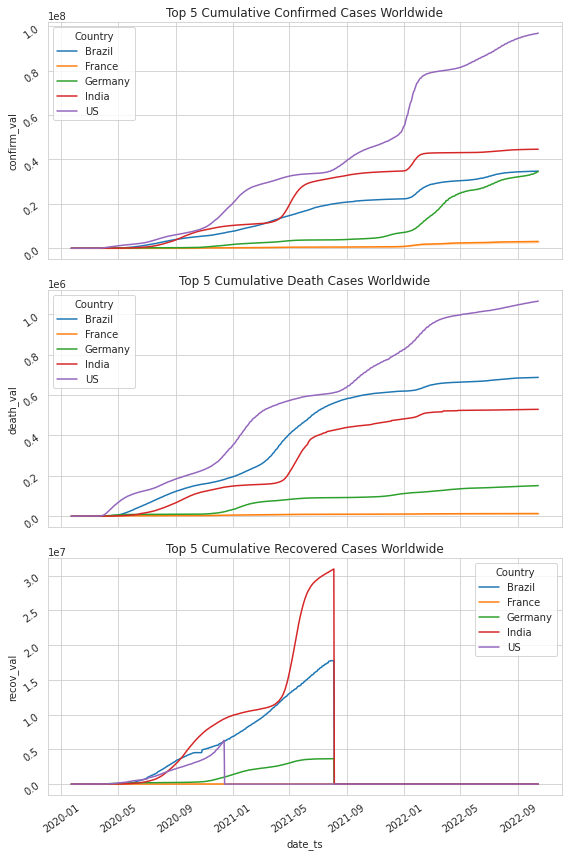

In [7]:
fig, axs =  plt.subplots(3, 1, figsize = (8, 12), squeeze=True, sharex=True)

sns.lineplot(data=sub_df, x="date_ts", y="confirm_val", hue="Country", ax=axs[0])
axs[0].tick_params(labelrotation = 35)
axs[0].set_title("Top 5 Cumulative Confirmed Cases Worldwide")

sns.lineplot(data=sub_df, x="date_ts", y="death_val", hue="Country", ax=axs[1])
axs[1].tick_params(labelrotation = 35)
axs[1].set_title("Top 5 Cumulative Death Cases Worldwide")

sns.lineplot(data=sub_df, x="date_ts", y="recov_val", hue="Country", ax=axs[2])
axs[2].tick_params(labelrotation = 35)
axs[2].set_title("Top 5 Cumulative Recovered Cases Worldwide")

plt.tight_layout()
plt.show()

## Daily Level Analysis

In [8]:
confirmed_daily = pd.concat([confirmed_global.iloc[:, :4], 
                             confirmed_global.iloc[:, 4:] - confirmed_global.iloc[:, 4:] \
                             .shift(periods=1, axis=1, fill_value=0)], axis=1)

death_daily = pd.concat([death_global.iloc[:, :4], 
                         death_global.iloc[:, 4:] - death_global.iloc[:, 4:] \
                         .shift(periods=1, axis=1, fill_value=0)], axis=1)

recovered_daily = pd.concat([recovered_global.iloc[:, :4],
                             recovered_global.iloc[:, 4:] - recovered_global.iloc[:, 4:] \
                             .shift(periods=1, axis=1, fill_value=0)], axis=1)

In [9]:
confrm_melt = melt_function(confirmed_daily, 'confirm_val')
death_melt = melt_function(death_daily, 'death_val')
recov_melt = melt_function(recovered_daily, 'recov_val')
confrm_melt = confrm_melt.rename(columns={'Country/Region': 'Country'})
death_melt = death_melt.rename(columns={'Country/Region': 'Country'})
recov_melt = recov_melt.rename(columns={'Country/Region': 'Country'})
confrm_melt.tail()

,Country,date_ts,confirm_val
288128,West Bank and Gaza,10/14/22,0
288129,Winter Olympics 2022,10/14/22,0
288130,Yemen,10/14/22,0
288131,Zambia,10/14/22,0
288132,Zimbabwe,10/14/22,0


In [10]:
final_melt = confrm_melt.merge(death_melt, on=['Country', 'date_ts'], how='left', suffixes=('_conf', '_dth')) \
                        .merge(recov_melt, on=['Country', 'date_ts'], how='left', suffixes=('_both', '_rcvr')) 
            #  .join(recov_melt, on=['Country', 'date_ts'], how='left', lsuffix='_conf', rsuffix='_rcv')
final_melt['date_ts'] = pd.to_datetime(final_melt['date_ts'])
final_melt.tail()

,Country,date_ts,confirm_val,death_val,recov_val
45410354,West Bank and Gaza,2022-10-14,0,0,0
45410355,Winter Olympics 2022,2022-10-14,0,0,0
45410356,Yemen,2022-10-14,0,0,0
45410357,Zambia,2022-10-14,0,0,0
45410358,Zimbabwe,2022-10-14,0,0,0


### Top 5 most affected

In [11]:
sub_df = final_melt[final_melt["Country"] \
                    .isin(["India", "US", "France", "Brazil", "Germany"])].copy()
sub_df

,Country,date_ts,confirm_val,death_val,recov_val
535,Brazil,2020-01-22,0,0,0
40158,France,2020-01-22,0,0,0
40159,France,2020-01-22,0,0,0
40160,France,2020-01-22,0,0,0
40161,France,2020-01-22,0,0,0
...,...,...,...,...,...
45406696,France,2022-10-14,58675,80,0
45406697,France,2022-10-14,58675,80,0
45406701,Germany,2022-10-14,91508,160,0
45406714,India,2022-10-14,2430,17,0


### Plotting Confirmed, Deaths, Recovery

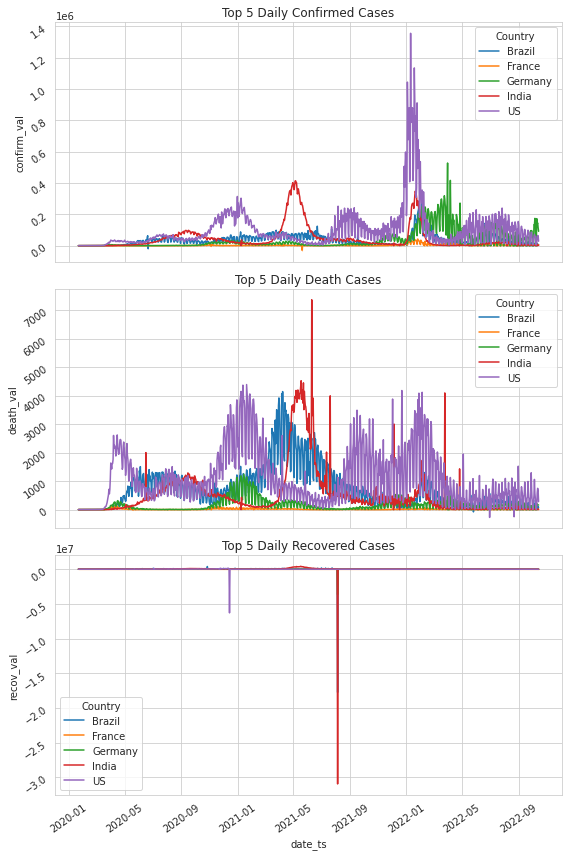

In [12]:
fig, axs =  plt.subplots(3, 1, figsize = (8, 12), squeeze=True, sharex=True)

sns.lineplot(data=sub_df, x="date_ts", y="confirm_val", hue="Country", ax=axs[0])
axs[0].tick_params(labelrotation = 35)
axs[0].set_title("Top 5 Daily Confirmed Cases")

sns.lineplot(data=sub_df, x="date_ts", y="death_val", hue="Country", ax=axs[1])
axs[1].tick_params(labelrotation = 35)
axs[1].set_title("Top 5 Daily Death Cases")

sns.lineplot(data=sub_df, x="date_ts", y="recov_val", hue="Country", ax=axs[2])
axs[2].tick_params(labelrotation = 35)
axs[2].set_title("Top 5 Daily Recovered Cases")

plt.tight_layout()
plt.show()

### Percentage Change

In [13]:
sub_df['pct_confirmed'] = sub_df['confirm_val'].pct_change() * 100
sub_df['pct_death'] = sub_df['death_val'].pct_change() * 100
sub_df['pct_recovered'] = sub_df['recov_val'].pct_change() * 100

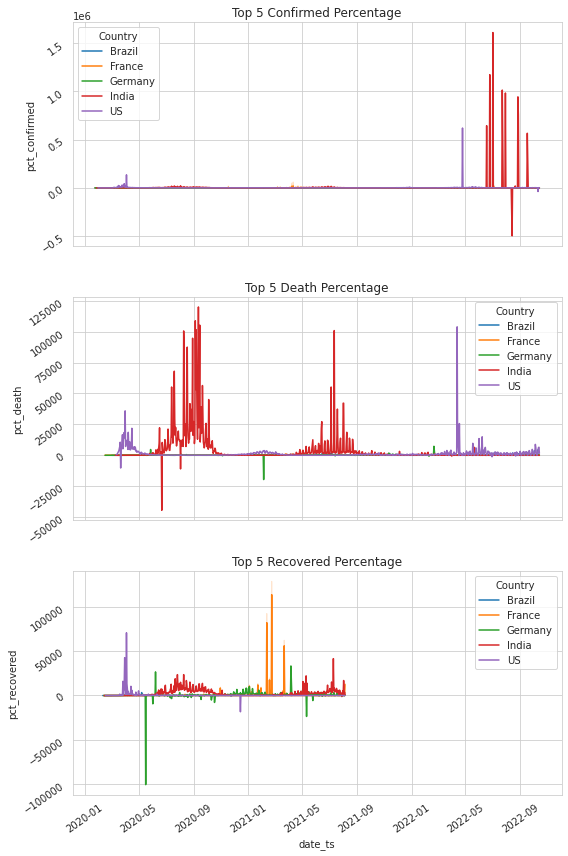

In [14]:
fig, axs =  plt.subplots(3, 1, figsize = (8, 12), squeeze=True, sharex=True)

sns.lineplot(data=sub_df, x="date_ts", y="pct_confirmed", hue="Country", ax=axs[0])
axs[0].tick_params(labelrotation = 35)
axs[0].set_title("Top 5 Confirmed Percentage")

sns.lineplot(data=sub_df, x="date_ts", y="pct_death", hue="Country", ax=axs[1])
axs[1].tick_params(labelrotation = 35)
axs[1].set_title("Top 5 Death Percentage")

sns.lineplot(data=sub_df, x="date_ts", y="pct_recovered", hue="Country", ax=axs[2])
axs[2].tick_params(labelrotation = 35)
axs[2].set_title("Top 5 Recovered Percentage")

plt.tight_layout()
plt.show()